# Climate Vulnearbility Metrics Indicators Wrangle
Author: Sofia Ingersoll

Date: 2024-07-02 


For context, we are using Cal Enviro Screen to identify disadvantaged communities, but want to expand to more communities based on other indicators. So it's less important that we understand where they overlap with Cal Enviro Screen, and more important that we understand where they don't overlap.


In simplest terms, the map should answer the question: For X indicator, what are the areas covered that are not already covered by CalEnviroScreen?


Looking at all of the individual datasets to identify the nuances in column names, cleaning, then combining into a single csv file to read in later.
There is a combination of 19 xlsx and 1 NETCDF file for the Climate Vulnerability Metrics Indicators.


Quick notes before diving in:
The funky column names that appeared in `identifying_ctracts_oversampling.ipynb` are not present here so that was likely a product of the for loop


In [18]:
# loading libraries
import os
import pandas as pd
import numpy as np
import geopandas as gpd 
import xarray as xr 
import rioxarray as rioxr
import rasterio 
import matplotlib.pyplot as plt

# Function to convert column names to snake_case
def to_snake_case(df):
    df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('\n', '_').str.lower()
    return df

**Cal Enviro Screen**

Considerations for plotting:

Will assign geometry according to county using a join of calenviro + a combined indicator df bc the county fips aren't included in Cal Enviro Screen.

I know EJScreen has all the info we need, so might bring that into the mix and then plot

In [19]:
# import CES shapefile
calenviro = gpd.read_file('../data/CalEnviroScreen/CES4 Final Shapefile.shp')

# clean naming for easier 
calenviro = to_snake_case(calenviro)

# crs config
calenviro = calenviro.to_crs('EPSG:2227')

calenviro.head(3)

,tract,zip,county,approxloc,totpop19,ciscore,ciscorep,ozone,ozonep,pm2_5,...,elderly65,hispanic,white,africanam,nativeam,othermult,shape_leng,shape_area,aapi,geometry
0,6.083002e+09,93454,Santa Barbara,Santa Maria,4495,36.019653,69.162885,0.034190,10.566273,7.567724,...,12.5028,68.9210,20.8899,0.4004,0.267,1.3126,6999.357689,2.847611e+06,8.2091,"POLYGON ((6580888.757 1071692.998, 6586374.203..."
1,6.083002e+09,93455,Santa Barbara,Santa Maria,13173,37.030667,70.637922,0.035217,11.561917,7.624775,...,5.3519,78.6229,13.2240,2.5051,0.000,0.9489,19100.578232,1.635292e+07,4.6990,"POLYGON ((6580888.757 1071692.998, 6580894.664..."
2,6.083002e+09,93454,Santa Barbara,Santa Maria,2398,31.213140,61.069087,0.034190,10.566273,7.548835,...,12.8857,65.7214,30.6088,0.9591,0.000,2.1685,4970.985897,1.352329e+06,0.5421,"POLYGON ((6586394.940 1074311.362, 6586374.203..."


In [27]:
calenviro.columns

Index(['tract', 'zip', 'county', 'approxloc', 'totpop19', 'ciscore',
       'ciscorep', 'ozone', 'ozonep', 'pm2_5', 'pm2_5_p', 'dieselpm',
       'dieselpm_p', 'pesticide', 'pesticidep', 'tox_rel', 'tox_rel_p',
       'traffic', 'trafficp', 'drinkwat', 'drinkwatp', 'lead', 'lead_p',
       'cleanup', 'cleanupp', 'gwthreat', 'gwthreatp', 'hazwaste', 'hazwastep',
       'impwatbod', 'impwatbodp', 'solwaste', 'solwastep', 'pollburd',
       'polburdsc', 'polburdp', 'asthma', 'asthmap', 'lowbirtwt', 'lowbirwp',
       'cardiovas', 'cardiovasp', 'educatn', 'educatp', 'ling_isol',
       'ling_isolp', 'poverty', 'povertyp', 'unempl', 'unemplp', 'housburd',
       'housburdp', 'popchar', 'popcharsc', 'popcharp', 'child_10',
       'pop_10_64', 'elderly65', 'hispanic', 'white', 'africanam', 'nativeam',
       'othermult', 'shape_leng', 'shape_area', 'aapi', 'geometry'],
      dtype='object')

<Axes: >

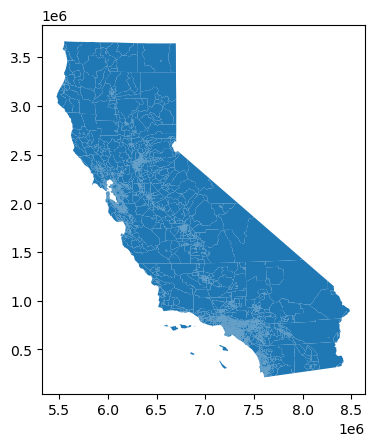

In [20]:
# this is our mask boundaries for the drought tiff
# we will want to see where the data sets do not overlap for each indicator
# aka an anti-join 
calenviro.plot()

### Data to Assigning Tracts for County Names 

EJScreen `cnty_name` to relate indicators  `county_name`

These county_names will be used to join with the CalEnviroScreen data to add geometry for each tract

In [46]:
# read in data & clean colnames 
ejscreen = to_snake_case(pd.read_csv('../data/EJSCREEN_2023_Tracts_StatePct_with_AS_CNMI_GU_VI.csv'))

# isolate CA
ejscreen = ejscreen[ejscreen.state_name == 'California']

# real quick let's convert the geoid10 format to scientific notation to match the other data
# using the g format specifier to automatically choose between fixed and scientific notation based on the number −
# let's also make our lives easier later and convert this column name to tract 
# this will not run if NaN are present, so this confirms the data is clean
ejscreen.loc[:, 'tract'] = ejscreen['id']

ejscreen_tracts = ejscreen[['tract', 'cnty_name']]

ejscreen_tracts.head(3)

,tract,cnty_name
4202,6001400100,Alameda
4203,6001400200,Alameda
4204,6001400300,Alameda


### Environmental

**Air Conditioning**

In [21]:
air_conditioning = pd.read_excel('../data/Climate_Vulnerability_Metric_Indicators/BRACE_AirConditioning_797_CO_RE_CA.xlsx', sheet_name=None)
 
# collect Clim. Vuln. Factor sheet names
ac_sheetnames = list(air_conditioning.keys())

# read in sheets as df
ac_README = air_conditioning[ac_sheetnames[0]]

ac_data = air_conditioning[ac_sheetnames[1]]

ac_dict = air_conditioning[ac_sheetnames[2]]

ac_dict

,Name,Definition,Type,Coding
0,ind_id,Indicator ID,N,26
1,ind_definition,Definition of indicator in plain language,T,Free text
2,reportyear,Year that the indicator was reported,T,2009
3,race_eth_code,numeric code for a race/ethnicity group,T,1 = American Indian; 2 = Asian or Pacific; 3 =...
4,race_eth_name,Name of race/ethnic group,T,American Indian; Asian or Pacific; Black or Af...
5,geotype,Type of geographic unit,T,CO County; RE Region; CA State
6,geotypevalue,Value of geographic unit,N,FIPS ID; region id
7,geoname,Name of geographic unit,T,"county, region name, state"
8,county_name,Name of county that geotype is in,T,NaN
9,county_fips,FIPS code of county that geotype is in,T,2-digit census state code (06) plus 3-digit ce...


In [50]:
# combine ejscreen's cnty_name & indicator's county_name to get tract info
ac_tract = ac_data.merge(ejscreen_tracts, how = 'inner', left_on = 'county_name', right_on = 'cnty_name')
ac_tract.head(3)


# convert tract columns to string for consistent merging
ac_tract.tract = ac_tract.tract.astype(str)
calenviro.tract = calenviro.tract.astype(str)

# combine with CalEnviro to get tract geometries 
ac_geo = ac_tract.merge(calenviro, how = 'inner', left_on = 'county_name', right_on = 'county')
# ensure ac_geo is a GeoDataFrame
ac_geo = gpd.GeoDataFrame(ac_geo, geometry='geometry', crs = calenviro.crs)

ac_geo.head(3)

,county_name,ind_id,ind_definition,reportyear,race_eth_code,race_eth_name,geotype,geotypevalue,geoname,county_fips,...,elderly65,hispanic,white,africanam,nativeam,othermult,shape_leng,shape_area,aapi,geometry
0,Alameda,797.0,Percent of households with air conditioning,2009.0,9.0,Total,CO,6001.0,Alameda,6001.0,...,13.6282,39.0835,19.4517,2.9017,0.9606,3.8223,5499.177517,1.273685e+06,33.7803,"POLYGON ((6109597.880 2057572.435, 6108993.110..."
1,Alameda,797.0,Percent of households with air conditioning,2009.0,9.0,Total,CO,6001.0,Alameda,6001.0,...,14.5768,54.4333,13.9742,3.9311,0.4017,1.4921,4229.811913,8.603767e+05,25.7676,"POLYGON ((6100666.476 2062035.380, 6101005.372..."
2,Alameda,797.0,Percent of households with air conditioning,2009.0,9.0,Total,CO,6001.0,Alameda,6001.0,...,11.2128,17.0481,15.0114,21.6018,1.3043,1.6476,3576.771195,5.172978e+05,43.3867,"POLYGON ((6060105.422 2117832.474, 6060931.214..."


In [51]:
# find non-overlapping regions
non_overlapping_ac = gpd.overlay(ac_geo, calenviro, how='difference')

# overlay CalEnviroScreen with this data as a map
non_overlapping_ac.plot()

In [ ]:
# save a csv of the non-overlapping regions

**Extreme Heat**

In [22]:
heat = pd.read_excel('../data/Climate_Vulnerability_Metric_Indicators/BRACE_ExtremeHeat_791_CO.xlsx', sheet_name=None)
 
# collect Clim. Vuln. Factor sheet names
heat_sheetnames = list(heat.keys())

# read in sheets as df
heat_README = heat[heat_sheetnames[0]]

heat_data = heat[heat_sheetnames[1]]

heat_dict = heat[heat_sheetnames[2]]

heat_dict

/Users/sofiaingersoll/anaconda3/envs/eds-env/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,Name,Definition,Type,Coding
0,ind_id,Indicator identification number,N,791
1,ind_definition,Indicator (full) name and definition in plain ...,T,NaN
2,reportyear,Year(s) that the indicator was reported,T,2040-2060 and 2080-2099
3,race_eth_code,Numeric code for a race/ethnicity group,T,9=Total
4,race_eth_name,Name of race/ethnicity group,T,Total
5,geotype,Type of geographic unit,T,CO= County CT=Census Tract
6,geotypevalue,Value of geographic unit,T,FIPS ID for counties (5-characters in length s...
7,geoname,Name of geographic unit,T,NaN
8,county_name,Name of county that geotype is in,T,NaN
9,county_fips,FIPS code of county that geotype is in,T,NaN


**Impervious Surfaces**

In [23]:
imp_surf = pd.read_excel('data/Climate_Vulnerability_Metric_Indicators/BRACE_ImperviousSurfaces_423_CT_PL_CO_RE_CA.xlsx', sheet_name=None)
 
# collect Clim. Vuln. Factor sheet names
imp_surf_sheetnames = list(imp_surf.keys())

# read in sheets as df
imp_surf_README = imp_surf[imp_surf_sheetnames[0]]

imp_surf_data = imp_surf[imp_surf_sheetnames[1]]

imp_surf_dict = imp_surf[imp_surf_sheetnames[2]]

imp_surf_dict

FileNotFoundError: [Errno 2] No such file or directory: 'data/Climate_Vulnerability_Metric_Indicators/BRACE_ImperviousSurfaces_423_CT_PL_CO_RE_CA.xlsx'

**Ozone**

In [ ]:
ozone = pd.read_excel('../data/Climate_Vulnerability_Metric_Indicators/BRACE_Ozone_801_CT_PL_CO_RE_CA.XLSX', sheet_name=None)
 
# collect Clim. Vuln. Factor sheet names
ozone_sheetnames = list(ozone.keys())

# read in sheets as df
ozone_README = ozone[ozone_sheetnames[0]]

ozone_data = ozone[ozone_sheetnames[1]]

ozone_dict = ozone[ozone_sheetnames[2]]

ozone_dict

/Users/sofiaingersoll/anaconda3/envs/eds-env/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,Name,Definition,Type,Coding
0,ind_id,Indicator identification number,N,801
1,ind_definition,Indicator (full) name and definition in plain ...,T,NaN
2,reportyear,Year(s) that the indicator was reported,T,2012-2014
3,race_eth_code,Numeric code for a race/ethnicity group,T,1=American Indian or Alaska Native; 2=Asian; 3...
4,race_eth_name,Name of race/ethnicity group,T,AIAN=American Indian or Alaska Native; Asian; ...
5,geotype,Type of geographic unit,T,CT=Census Tract; CO= County; RE=Adaptation Imp...
6,geotypevalue,Value of geographic unit,T,Census tract code (11-characters in length sta...
7,geoname,Name of geographic unit,T,NaN
8,county_name,Name of county that geotype is in,T,NaN
9,county_fips,FIPS code of county that geotype is in,T,NaN


**PM25 Levels**

In [ ]:
pm25 = pd.read_excel('../data/Climate_Vulnerability_Metric_Indicators/BRACE_PM25levels_776_CT_PL_CO_RE_CA.XLSX', sheet_name=None)
 
# collect Clim. Vuln. Factor sheet names
pm25_sheetnames = list(pm25.keys())

# read in sheets as df
pm25_README = pm25[pm25_sheetnames[0]]

pm25_data = pm25[pm25_sheetnames[1]]

pm25_dict = pm25[pm25_sheetnames[2]]

pm25_dict

,Name,Definition,Type,Coding
0,ind_id,Indicator identification number,N,776
1,ind_definition,Indicator (full) name and definition in plain ...,T,NaN
2,reportyear,Year(s) that the indicator was reported,T,"2009-2011, 2012-2014"
3,race_eth_code,Numeric code for a race/ethnicity group,T,1=American Indian or Alaska Native; 2=Asian; 3...
4,race_eth_name,Name of race/ethnicity group,T,AIAN=American Indian or Alaska Native; Asian; ...
5,geotype,Type of geographic unit,T,CT=Census Tract; PL=Place; CD=County Subdivisi...
6,geotypevalue,Value of geographic unit,T,Census tract code (11-characters in length sta...
7,geoname,Name of geographic unit,T,NaN
8,county_name,Name of county that geotype is in,T,NaN
9,county_fips,FIPS code of county that geotype is in,T,NaN


**Sea Level Rise (SRL)**

In [ ]:
slr = pd.read_excel('../data/Climate_Vulnerability_Metric_Indicators/BRACE_SLR_784_CT_PL_CO_RE_CA_11-1-2016.xlsx', sheet_name=None)
 
# collect Clim. Vuln. Factor sheet names
slr_sheetnames = list(slr.keys())

# read in sheets as df
slr_README = slr[slr_sheetnames[0]]

slr_data = slr[slr_sheetnames[1]]

slr_dict = slr[slr_sheetnames[2]]

slr_dict

,Name,Definition,Type,Coding
0,ind_id,Indicator identification number,N,784
1,ind_definition,Indicator (full) name and definition in plain ...,T,NaN
2,reportyear,Year(s) that the indicator was reported,T,2009
3,race_eth_code,Numeric code for a race/ethnicity group,T,1=American Indian or Alaska Native; 2=Asian; 3...
4,race_eth_name,Name of race/ethnicity group,T,AIAN=American Indian or Alaska Native; Asian; ...
5,geotype,Type of geographic unit,T,CT=Census Tract; PL=Place; CD=County Subdivisi...
6,geotypevalue,Value of geographic unit,T,Census tract code (11-characters in length sta...
7,geoname,Name of geographic unit,T,NaN
8,county_name,Name of county that geotype is in,T,NaN
9,county_fips,FIPS code of county that geotype is in,T,NaN


**Tree Canopy**

In [ ]:
tree_canopy = pd.read_excel('../data/Climate_Vulnerability_Metric_Indicators/BRACE_TreeCanopy_458_CT_PL_CO_RE_CA.xlsx', sheet_name=None)
 
# collect Clim. Vuln. Factor sheet names
tree_canopy_sheetnames = list(tree_canopy.keys())

# read in sheets as df
tree_canopy_README = tree_canopy[tree_canopy_sheetnames[0]]

tree_canopy_data = tree_canopy[tree_canopy_sheetnames[1]]

tree_canopy_dict = tree_canopy[tree_canopy_sheetnames[2]]

tree_canopy_dict

,Name,Definition,Type,Coding
0,ind_id,Indicator identification number,N,458
1,ind_definition,Indicator (full) name and definition in plain ...,T,NaN
2,reportyear,Year(s) that the indicator was reported,T,2011
3,race_eth_code,Numeric code for a race/ethnicity group,T,1=American Indian or Alaska Native; 2=Asian; 3...
4,race_eth_name,Name of race/ethnicity group,T,AIAN=American Indian or Alaska Native; Asian; ...
5,geotype,Type of geographic unit,T,CT=Census Tract; PL=Place; CD=County Subdivisi...
6,geotypevalue,Value of geographic unit,T,Census tract code (11-characters in length sta...
7,geoname,Name of geographic unit,T,NaN
8,county_name,Name of county that geotype is in,T,NaN
9,county_fips,FIPS code of county that geotype is in,T,NaN


**Wildfire**

In [ ]:
wildfire = pd.read_excel('../data/Climate_Vulnerability_Metric_Indicators/BRACE_Wildfire_786_CT_PL_CO_RE_CA.xlsx', sheet_name=None)
 
# collect Clim. Vuln. Factor sheet names
wildfire_sheetnames = list(wildfire.keys())

# read in sheets as df
wildfire_README = wildfire[wildfire_sheetnames[0]]

wildfire_data = wildfire[wildfire_sheetnames[1]]

wildfire_dict = wildfire[wildfire_sheetnames[2]]

wildfire_dict

,Name,Definition,Type,Coding
0,ind_id,Indicator identification number,N,786
1,ind_definition,Indicator (full) name and definition in plain ...,T,NaN
2,reportyear,Year(s) that the indicator was reported,T,2007
3,race_eth_code,Numeric code for a race/ethnicity group,T,1=American Indian or Alaska Native; 2=Asian; 3...
4,race_eth_name,Name of race/ethnicity group,T,AIAN=American Indian or Alaska Native; Asian; ...
5,geotype,Type of geographic unit,T,CT=Census Tract; PL=Place; CD=County Subdivisi...
6,geotypevalue,Value of geographic unit,T,Census tract code (11-characters in length sta...
7,geoname,Name of geographic unit,T,NaN
8,county_name,Name of county that geotype is in,T,NaN
9,county_fips,FIPS code of county that geotype is in,T,NaN


**Drought**

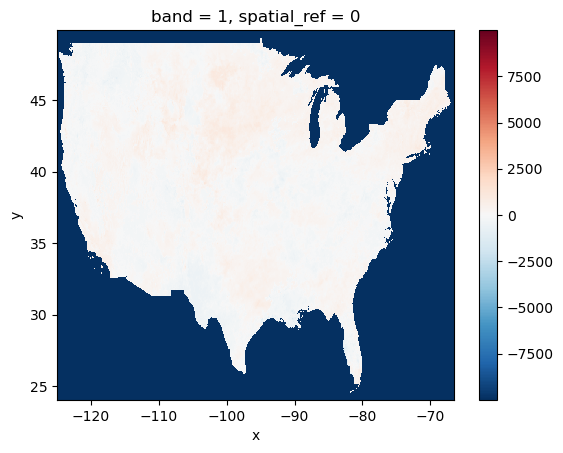

In [ ]:
# load drought tif file
folder = '../data/Climate_Vulnerability_Metric_Indicators/'
drought_path = os.path.join(folder, 'pdsi_current_PRISM.tif')

drought_df = rioxr.open_rasterio(drought_path,
                                 crs = 'EPSG:2227')

# this tiff file needs a mask for CA
drought_df.plot()

### Social

**Car Ownership**

In [ ]:
own_car = pd.read_excel('../data/Climate_Vulnerability_Metric_Indicators/BRACE_CarOwnership_37_CT_PL_CO_RE_CA.XLSX', sheet_name=None)
 
# collect Clim. Vuln. Factor sheet names
own_car_sheetnames = list(own_car.keys())

# read in sheets as df
own_car_README = own_car[own_car_sheetnames[0]]

own_car_data = own_car[own_car_sheetnames[1]]

own_car_dict = own_car[own_car_sheetnames[2]]

own_car_dict

,Name,Definition,Type,Coding
0,ind_id,Indicator identification number,N,37
1,ind_definition,Indicator (full) name and definition in plain ...,T,NaN
2,reportyear,Year(s) that the indicator was reported,T,2006-2010 or 2011-2015
3,race_eth_code,Numeric code for a race/ethnicity group,T,1=American Indian or Alaska Native; 2=Asian; 3...
4,race_eth_name,Name of race/ethnicity group,T,AIAN=American Indian or Alaska Native; Asian; ...
5,geotype,Type of geographic unit,T,CT=Census Tract; PL=Place; CD=County Subdivisi...
6,geotypevalue,Value of geographic unit,T,Census tract code (11-characters in length sta...
7,geoname,Name of geographic unit,T,NaN
8,county_name,Name of county that geotype is in,T,NaN
9,county_fips,FIPS code of county that geotype is in,T,NaN


**Children**

In [ ]:
children = pd.read_excel('../data/Climate_Vulnerability_Metric_Indicators/BRACE_children_788_CT_PL_CO_RE_CA.XLSX', sheet_name=None)
 
# collect Clim. Vuln. Factor sheet names
children_sheetnames = list(children.keys())

# read in sheets as df
children_README = children[children_sheetnames[0]]

children_data = children[children_sheetnames[1]]

children_dict = children[children_sheetnames[2]]

children_dict

,Name,Definition,Type,Coding
0,ind_id,Indicator identification number,N,788
1,ind_definition,Indicator (full) name and definition in plain ...,T,NaN
2,reportyear,Year(s) that the indicator was reported,T,2010 or 2011-2015
3,race_eth_code,Numeric code for a race/ethnicity group,T,1=American Indian or Alaska Native; 2=Asian; 3...
4,race_eth_name,Name of race/ethnicity group,T,AIAN=American Indian or Alaska Native; Asian; ...
5,geotype,Type of geographic unit,T,CT=Census Tract; PL=Place; CD=County Subdivisi...
6,geotypevalue,Value of geographic unit,T,Census tract code (11-characters in length sta...
7,geoname,Name of geographic unit,T,NaN
8,county_name,Name of county that geotype is in,T,NaN
9,county_fips,FIPS code of county that geotype is in,T,NaN


**Disabled**

In [ ]:
disabled = pd.read_excel('../data/Climate_Vulnerability_Metric_Indicators/BRACE_Disability_795_CT_PL_CO_RE_CA.XLSX', sheet_name=None)
 
# collect Clim. Vuln. Factor sheet names
disabled_sheetnames = list(disabled.keys())

# read in sheets as df
disabled_README = disabled[disabled_sheetnames[0]]

disabled_data = disabled[disabled_sheetnames[1]]

disabled_dict = disabled[disabled_sheetnames[2]]

disabled_dict

,Name,Definition,Type,Coding
0,ind_id,Indicator identification number,N,795
1,ind_definition,Indicator (full) name and definition in plain ...,T,NaN
2,reportyear,Year(s) that the indicator was reported,T,2008-2012 or 2011-2015
3,race_eth_code,Numeric code for a race/ethnicity group,T,1=American Indian or Alaska Native; 2=Asian; 3...
4,race_eth_name,Name of race/ethnicity group,T,AIAN=American Indian or Alaska Native; Asian; ...
5,geotype,Type of geographic unit,T,CT=Census Tract; PL=Place; CD=County Subdivisi...
6,geotypevalue,Value of geographic unit,T,Census tract code (11-characters in length sta...
7,geoname,Name of geographic unit,T,NaN
8,county_name,Name of county that geotype is in,T,NaN
9,county_fips,FIPS code of county that geotype is in,T,NaN


**Elderly Over 65**

In [ ]:
elderly = pd.read_excel('../data/Climate_Vulnerability_Metric_Indicators/BRACE_elderly65over_789_CT_PL_CO_RE_CA.XLSX', sheet_name=None)
 
# collect Clim. Vuln. Factor sheet names
elderly_sheetnames = list(elderly.keys())

# read in sheets as df
elderly_README = elderly[elderly_sheetnames[0]]

elderly_data = elderly[elderly_sheetnames[1]]

elderly_dict = elderly[elderly_sheetnames[2]]

elderly_dict

,Name,Definition,Type,Coding
0,ind_id,Indicator identification number,N,789
1,ind_definition,Indicator (full) name and definition in plain ...,T,NaN
2,reportyear,Year(s) that the indicator was reported,T,2010 or 2011-2015
3,race_eth_code,Numeric code for a race/ethnicity group,T,1=American Indian or Alaska Native; 2=Asian; 3...
4,race_eth_name,Name of race/ethnicity group,T,AIAN=American Indian or Alaska Native; Asian; ...
5,geotype,Type of geographic unit,T,CT=Census Tract; PL=Place; CD=County Subdivisi...
6,geotypevalue,Value of geographic unit,T,Census tract code (11-characters in length sta...
7,geoname,Name of geographic unit,T,NaN
8,county_name,Name of county that geotype is in,T,NaN
9,county_fips,FIPS code of county that geotype is in,T,NaN


**Linguistic Isolation**

In [ ]:
ling_isolation = pd.read_excel('../data/Climate_Vulnerability_Metric_Indicators/BRACE_LinguisticIsolation_800_CT_PL_CO_RE_CA.XLSX', sheet_name=None)
 
# collect Clim. Vuln. Factor sheet names
ling_isolation_sheetnames = list(ling_isolation.keys())

# read in sheets as df
ling_isolation_README = ling_isolation[ling_isolation_sheetnames[0]]

ling_isolation_data = ling_isolation[ling_isolation_sheetnames[1]]

ling_isolation_dict = ling_isolation[ling_isolation_sheetnames[2]]

ling_isolation_dict

,Name,Definition,Type,Coding
0,ind_id,Indicator identification number,N,800
1,ind_definition,Indicator (full) name and definition in plain ...,T,NaN
2,reportyear,Year(s) that the indicator was reported,T,2006-2010 or 2011-2015
3,race_eth_code,Numeric code for a race/ethnicity group,T,9=Total
4,race_eth_name,Name of race/ethnicity group,T,Total
5,geotype,Type of geographic unit,T,CT=Census Tract; PL=Place; CD=County Subdivisi...
6,geotypevalue,Value of geographic unit,T,Census tract code (11-characters in length sta...
7,geoname,Name of geographic unit,T,NaN
8,county_name,Name of county that geotype is in,T,NaN
9,county_fips,FIPS code of county that geotype is in,T,NaN


**Outdoor Workers**

In [ ]:
outdoor = pd.read_excel('../data/Climate_Vulnerability_Metric_Indicators/BRACE_OutdoorWorkers_790_CT_PL_CO_RE_CA.XLSX', sheet_name=None)
 
# collect Clim. Vuln. Factor sheet names
outdoor_sheetnames = list(outdoor.keys())

# read in sheets as df
outdoor_README = outdoor[outdoor_sheetnames[0]]

outdoor_data = outdoor[outdoor_sheetnames[1]]

outdoor_dict = outdoor[outdoor_sheetnames[2]]

outdoor_dict

,Name,Definition,Type,Coding
0,ind_id,Indicator identification number,N,790
1,ind_definition,Indicator (full) name and definition in plain ...,T,NaN
2,reportyear,Year(s) that the indicator was reported,T,2006-2010 or 2011-2015
3,race_eth_code,Numeric code for a race/ethnicity group,T,1=American Indian or Alaska Native; 2=Asian; 3...
4,race_eth_name,Name of race/ethnicity group,T,AIAN=American Indian or Alaska Native; Asian; ...
5,geotype,Type of geographic unit,T,CT=Census Tract; PL=Place; CD=County Subdivisi...
6,geotypevalue,Value of geographic unit,T,Census tract code (11-characters in length sta...
7,geoname,Name of geographic unit,T,NaN
8,county_name,Name of county that geotype is in,T,NaN
9,county_fips,FIPS code of county that geotype is in,T,NaN


**Race**

In [ ]:
race = pd.read_excel('../data/Climate_Vulnerability_Metric_Indicators/BRACE_race_795_CT_PL_CO_RE_CA.XLSX', sheet_name=None)
 
# collect Clim. Vuln. Factor sheet names
race_sheetnames = list(race.keys())

# read in sheets as df
race_README = race[race_sheetnames[0]]

race_data = race[race_sheetnames[1]]

race_dict = race[race_sheetnames[2]]

race_dict

,Name,Definition,Type,Coding
0,ind_id,Indicator identification number,N,794
1,ind_definition,Indicator (full) name and definition in plain ...,T,NaN
2,reportyear,Year(s) that the indicator was reported,T,2010 or 2011-2015
3,race_eth_code,Numeric code for a race/ethnicity group,T,1=American Indian or Alaska Native; 2=Asian; 3...
4,race_eth_name,Name of race/ethnicity group,T,AIAN=American Indian or Alaska Native; Asian; ...
5,geotype,Type of geographic unit,T,CT=Census Tract; PL=Place; CD=County Subdivisi...
6,geotypevalue,Value of geographic unit,T,Census tract code (11-characters in length sta...
7,geoname,Name of geographic unit,T,NaN
8,county_name,Name of county that geotype is in,T,NaN
9,county_fips,FIPS code of county that geotype is in,T,NaN


**Crime**

In [ ]:
crime = pd.read_excel('../data/Climate_Vulnerability_Metric_Indicators/HCI_Crime_752_PL_CO_RE_CA_2000-2013_21OCT15.xlsx', sheet_name=None)
 
# collect Clim. Vuln. Factor sheet names
crime_sheetnames = list(crime.keys())

# read in sheets as df
crime_README = crime[crime_sheetnames[0]]

crime_data = crime[crime_sheetnames[1]]

crime_dict = crime[crime_sheetnames[2]]

crime_dict

,Name,Definition,Type,Width/Format,Coding/Comments
0,ind_id,Indicator ID,N,3,752
1,ind_definition,Definition of indicator in plain language,T,255,Free text
2,reportyear,Year(s) that the indicator was reported,N,4,"2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007..."
3,race_eth_code,numeric code for a race/ethnicity group,N,1,9=Total
4,race_eth_name,Name of race/ethnic group,T,5,Total
5,geotype,Type of geographic unit,T,2,"PL: Place (including city, town and census des..."
6,geotypevalue,Value of geographic unit,N,5,"5-digit FIPS place code, 5-digit FIPS county c..."
7,geoname,Name of geographic unit,T,30,"place name, county name, region name, state name"
8,county_fips,Name of county that geotype is in,T,25,NA for geotype RE and CA
9,county_name,FIPS code of county that geotype is in,T,5,2-digit census state code (06) plus 3-digit ce...


**Educational Attainment**

In [ ]:
education = pd.read_excel('../data/Climate_Vulnerability_Metric_Indicators/HCI_Educational_Attainment_355_CA_RE_CO_CD_PL_CT_Total2018-06-12-ADA_BH.xlsx', sheet_name=None)
 
# collect Clim. Vuln. Factor sheet names
education_sheetnames = list(education.keys())

# read in sheets as df
education_README = education[education_sheetnames[0]]

education_data = education[education_sheetnames[1]]

education_dict = education[education_sheetnames[2]]

education_dict

,COLUMN NAME,DEFINITION,FORMAT,CODING
0,ind_id,Indicator identification number,String,355; code for internal use in the Office of He...
1,ind_definition,Definition of indicator in plain language,String,Percent of population age 25 and up with a fou...
2,reportyear,Year(s) that the indicator was reported,String,"2000, 2006-2010, 2011-2015. 2000 data is from..."
3,race_eth_code,Numeric code for a race/ethnicity group,String,1=American Indian or Alaska Native (AIAN); 2=A...
4,race_eth_name,Name of race/ethnic group,String,AIAN=American Indian or Alaska Native; Asian; ...
5,geotype,Type of geographic unit,String,"CT=Census tract; PL=Place (includes cities, to..."
6,geotypevalue,Value of geographic unit,String,Census tract code (11-characters in length sta...
7,geoname,Name of geographic unit,String,"census tract name, place name, county subdivis..."
8,county_name,Name of county that geotype is in,String,Not available for geotypes RE and CA
9,county_fips,FIPS code of county that geotype is in,String,2-digit census state code (06) plus 3-digit ce...


**Poverty Rate**

In [ ]:
poverty = pd.read_excel('../data/Climate_Vulnerability_Metric_Indicators/HCI_PovertyRate_200FPL_754_CA_RE_CO_CD_PL_PUMA_CT_20112015_20122016_Total2018-10-01-ADA.xlsx', sheet_name=None)
 
# collect Clim. Vuln. Factor sheet names
poverty_sheetnames = list(poverty.keys())

# read in sheets as df
poverty_README = poverty[poverty_sheetnames[0]]

poverty_data = poverty[poverty_sheetnames[1]]

poverty_dict = poverty[poverty_sheetnames[2]]

poverty_dict

,COLUMN NAME,DEFINITION,FORMAT,CODING
0,ind_id,Indicator identification number,String,754; code for internal use in the Office of He...
1,ind_definition,Definition of indicator in plain language,String,Percent of population living <200% FPL
2,reportyear,Year(s) that the indicator was reported,String,2011-2015 (overall poverty); 2012-2016 (child ...
3,race_eth_code,Numeric code for a race/ethnicity group,String,1=American Indian or Alaska Native (AIAN); 2=A...
4,race_eth_name,Name of race/ethnic group,String,AIAN=American Indian or Alaska Native; Asian; ...
5,geotype,Type of geographic unit,String,CT=Census tract; PUMA=Public Use Microdata Are...
6,geotypevalue,Value of geographic unit,String,Census tract code (11-characters in length sta...
7,geoname,Name of geographic unit,String,"census tract name, place name, county subdivis..."
8,county_name,Name of county that geotype is in,String,"Not available for geotypes CA, RE, and PUMA"
9,county_fips,FIPS code of county that geotype is in,String,2-digit census state code (06) plus 3-digit ce...


### Governance

**Insurance**

In [ ]:
insurance = pd.read_excel('../data/Climate_Vulnerability_Metric_Indicators/BRACE_Insurance_187_CT_PL_CO_RE_CA.XLSX', sheet_name=None)
 
# collect Clim. Vuln. Factor sheet names
insurance_sheetnames = list(insurance.keys())

# read in sheets as df
insurance_README = insurance[insurance_sheetnames[0]]

insurance_data = insurance[insurance_sheetnames[1]]

insurance_dict = insurance[insurance_sheetnames[2]]

insurance_dict

,Name,Definition,Type,Coding
0,ind_id,Indicator identification number,N,795
1,ind_definition,Indicator (full) name and definition in plain ...,T,NaN
2,reportyear,Year(s) that the indicator was reported,T,"2009-2013, 2011-2013, 2011-2015, 2015 (alone)"
3,race_eth_code,Numeric code for a race/ethnicity group,T,1=American Indian or Alaska Native; 2=Asian; 3...
4,race_eth_name,Name of race/ethnicity group,T,AIAN=American Indian or Alaska Native; Asian; ...
5,geotype,Type of geographic unit,T,CT=Census Tract; PL=Place; CD=County Subdivisi...
6,geotypevalue,Value of geographic unit,T,Census tract code (11-characters in length sta...
7,geoname,Name of geographic unit,T,NaN
8,county_name,Name of county that geotype is in,T,NaN
9,county_fips,FIPS code of county that geotype is in,T,NaN


In [ ]:
# combining each 